# DL2DWH Lab

In this lab you are asked to cover the following points:
1. Data ingestion
2. Data understanding
3. Design and build a relational DWH
4. Query the DWH with Tableau (Desktop)
5. (Bonus) Plot the provenance graph

In [1]:
!pip install awswrangler
!pip install pandas
!pip install sklearn
!pip install prov
!pip install seaborn
!pip install pydot
!pip install graphviz
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pyt

In [2]:
import pandas as pd
import awswrangler as wr
import seaborn as sns
import prov

## Data preparation

In [3]:
# get the raw data
df = pd.read_csv('http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.orig.csv')
df

,Birthdate,Brand Name,C. City,C. Country,C. State,Category,Coffee Bar,Cost,Customer (Birthdate),Customer (Card),...,Subcategory,Subcategory (Dep),Subcategory (Family),Type,Video Store,Yearly Income,Number of Records,Store Cost,Store Sales,Unit Sales
0,2/25/1954,CDR,Walla Walla,USA,WA,Jams and Jellies,0,0,3446,3446,...,Jam,Jam,Jam,Small Grocery,0,$30K - $50K,1,3.0480,7.62,3
1,2/25/1954,Landslide,Walla Walla,USA,WA,Jams and Jellies,0,0,3446,3446,...,Peanut Butter,Peanut Butter,Peanut Butter,Small Grocery,0,$30K - $50K,1,1.9740,4.20,3
2,2/25/1954,Fort West,Walla Walla,USA,WA,Snack Foods,0,0,3446,3446,...,Chips,Chips,Chips,Small Grocery,0,$30K - $50K,1,5.2380,11.64,3
3,2/25/1954,Horatio,Walla Walla,USA,WA,Snack Foods,0,0,3446,3446,...,Dried Fruit,Dried Fruit,Dried Fruit,Small Grocery,0,$30K - $50K,1,1.8744,5.68,2
4,2/25/1954,Red Wing,Walla Walla,USA,WA,Paper Products,0,0,3446,3446,...,Paper Wipes,Paper Wipes,Paper Wipes,Small Grocery,0,$30K - $50K,1,1.7384,4.24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86832,6/19/1915,Super,Downey,USA,CA,Jams and Jellies,1,12820,5566,5566,...,Jelly,Jelly,Jelly,Gourmet Supermarket,1,$50K - $70K,1,3.7152,7.74,3
86833,6/19/1915,Booker,Downey,USA,CA,Dairy,1,12820,5566,5566,...,Cheese,Cheese,Cheese,Gourmet Supermarket,1,$50K - $70K,1,2.0535,5.55,3
86834,6/19/1915,Club,Downey,USA,CA,Dairy,1,12820,5566,5566,...,Cheese,Cheese,Cheese,Gourmet Supermarket,1,$50K - $70K,1,5.9250,11.85,3
86835,6/19/1915,Imagine,Downey,USA,CA,Frozen Desserts,1,12820,5566,5566,...,Ice Cream,Ice Cream,Ice Cream,Gourmet Supermarket,1,$50K - $70K,1,2.6322,6.42,2


In [4]:
# take a look at the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86837 entries, 0 to 86836
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Birthdate              86837 non-null  object 
 1   Brand Name             86837 non-null  object 
 2   C. City                86837 non-null  object 
 3   C. Country             86837 non-null  object 
 4   C. State               86837 non-null  object 
 5   Category               86837 non-null  object 
 6   Coffee Bar             86837 non-null  int64  
 7   Cost                   86837 non-null  int64  
 8   Customer (Birthdate)   86837 non-null  int64  
 9   Customer (Card)        86837 non-null  int64  
 10  Customer (Education)   86837 non-null  int64  
 11  Customer (Income)      86837 non-null  int64  
 12  Customer (Location)    86837 non-null  int64  
 13  Customer (Occupation)  86837 non-null  int64  
 14  Customer (Sex)         86837 non-null  int64  
 15  Cu

In [5]:
# select a subset of columns
columns = [
    "C. City", "C. Country", "C. State", "Customer (Location)", "Yearly Income",
    "Category", "Subcategory", "Family", "Product (Category)",
    "S. City", "S. Country", "S. State", "Store", "Type",
    "Sales Date"
]
df = df[columns + ["Store Cost", "Store Sales", "Unit Sales"]].groupby(columns).first().reset_index()

In [6]:
# rename some columns
if "Customer (Location)" in df.columns:
    df = df.rename(columns={
        'Customer (Location)': 'Customer',
        'Product (Category)': 'Product'
    })
df

,C. City,C. Country,C. State,Customer,Yearly Income,Category,Subcategory,Family,Product,S. City,S. Country,S. State,Store,Type,Sales Date,Store Cost,Store Sales,Unit Sales
0,Albany,USA,OR,117,$90K - $110K,Baking Goods,Cooking Oil,Food,Super Corn Oil,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,2.1177,5.43,3
1,Albany,USA,OR,117,$90K - $110K,Baking Goods,Sauces,Food,Landslide Tomato Sauce,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,1.6500,5.00,4
2,Albany,USA,OR,117,$90K - $110K,Baking Goods,Sugar,Food,Landslide Brown Sugar,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,5.3760,11.20,4
3,Albany,USA,OR,117,$90K - $110K,Bathroom Products,Conditioner,Non-Consumable,Consolidated Silky Smooth Hair Conditioner,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,1.1466,2.94,2
4,Albany,USA,OR,117,$90K - $110K,Beer and Wine,Wine,Drink,Pearl Merlot Wine,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,0.9288,2.16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86824,Yakima,USA,WA,10226,$10K - $30K,Jams and Jellies,Peanut Butter,Food,Plato Chunky Peanut Butter,Yakima,USA,WA,23,Mid-Size Grocery,6/30/1997 12:00:00 AM,1.9600,4.90,2
86825,Yakima,USA,WA,10226,$10K - $30K,Meat,Hot Dogs,Food,Cutting Edge Chicken Hot Dogs,Yakima,USA,WA,23,Mid-Size Grocery,6/30/1997 12:00:00 AM,1.4229,4.59,3
86826,Yakima,USA,WA,10226,$10K - $30K,Pizza,Pizza,Food,PigTail Frozen Pepperoni Pizza,Yakima,USA,WA,23,Mid-Size Grocery,3/1/1997 12:00:00 AM,1.0752,3.36,2
86827,Yakima,USA,WA,10226,$10K - $30K,Vegetables,Fresh Vegetables,Food,Ebony Garlic,Yakima,USA,WA,23,Mid-Size Grocery,2/11/1997 12:00:00 AM,4.3680,10.40,4


In [7]:
def csv_download_link(df, csv_file_name, delete_prompt=True):
    """Display a download link to load a data frame as csv from within a Jupyter notebook"""
    df.to_csv(csv_file_name, index=False)
    from IPython.display import FileLink
    display(FileLink(csv_file_name))
    if delete_prompt:
        a = input('Press enter to delete the file after you have downloaded it.')
        import os
        os.remove(csv_file_name)

def download_slice(fr, to, bins):
    l = int(df.shape[0] / bins)
    csv_download_link(df[fr * l: to * l], 'slice-{}-{}.csv'.format(fr, to), delete_prompt=False)

bins = 3
for i in range(1, bins + 1):
    download_slice(i - 1, i, bins)
    

/home/ec2-user/SageMaker/slice-0-1.csv

/home/ec2-user/SageMaker/slice-1-2.csv

/home/ec2-user/SageMaker/slice-2-3.csv

## Data ingestion

- Upload the following files in S3 (remember the naming conventions of the data lake areas!)
    - [http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-0-1.v0.0.1.csv](http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-0-1.v0.0.1.csv)
    - [http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-1-2.v0.0.1.csv](http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-1-2.v0.0.1.csv)
    - [http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-2-3.v0.0.1.csv](http://big.csr.unibo.it/projects/nosql-datasets/sales_fact_1997.slice-2-3.v0.0.1.csv)
- Merge/Append them into a single Pandas DataFrame
    - Which is the underlying assumption so that `append` works?
    - See [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.append.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.append.html)
- Save the processed dataset into S3

In [8]:
landing_bucket = "s3://landing-raw-sales-123/"
staging_bucket = "s3://staging-clean-sales-123/"

file_names = ["sales_fact_1997.slice-0-1.v0.0.1.csv", "sales_fact_1997.slice-1-2.v0.0.1.csv", "sales_fact_1997.slice-2-3.v0.0.1.csv",]

In [9]:
# import from S3
df = wr.s3.read_csv(landing_bucket + file_names[0])
for file_name in file_names[1:]:
    df = df.append(wr.s3.read_csv(landing_bucket + file_name), ignore_index=True)
df

,C. City,C. Country,C. State,Customer,Yearly Income,Category,Subcategory,Family,Product,S. City,S. Country,S. State,Store,Type,Sales Date,Store Cost,Store Sales,Unit Sales
0,Albany,USA,OR,117,$90K - $110K,Baking Goods,Cooking Oil,Food,Super Corn Oil,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,2.1177,5.43,3
1,Albany,USA,OR,117,$90K - $110K,Baking Goods,Sauces,Food,Landslide Tomato Sauce,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,1.6500,5.00,4
2,Albany,USA,OR,117,$90K - $110K,Baking Goods,Sugar,Food,Landslide Brown Sugar,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,5.3760,11.20,4
3,Albany,USA,OR,117,$90K - $110K,Bathroom Products,Conditioner,Non-Consumable,Consolidated Silky Smooth Hair Conditioner,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,1.1466,2.94,2
4,Albany,USA,OR,117,$90K - $110K,Beer and Wine,Wine,Drink,Pearl Merlot Wine,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,0.9288,2.16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86824,Yakima,USA,WA,10226,$10K - $30K,Jams and Jellies,Peanut Butter,Food,Plato Chunky Peanut Butter,Yakima,USA,WA,23,Mid-Size Grocery,6/30/1997 12:00:00 AM,1.9600,4.90,2
86825,Yakima,USA,WA,10226,$10K - $30K,Meat,Hot Dogs,Food,Cutting Edge Chicken Hot Dogs,Yakima,USA,WA,23,Mid-Size Grocery,6/30/1997 12:00:00 AM,1.4229,4.59,3
86826,Yakima,USA,WA,10226,$10K - $30K,Pizza,Pizza,Food,PigTail Frozen Pepperoni Pizza,Yakima,USA,WA,23,Mid-Size Grocery,3/1/1997 12:00:00 AM,1.0752,3.36,2
86827,Yakima,USA,WA,10226,$10K - $30K,Vegetables,Fresh Vegetables,Food,Ebony Garlic,Yakima,USA,WA,23,Mid-Size Grocery,2/11/1997 12:00:00 AM,4.3680,10.40,4


In [10]:
# import directly from the sources
url = "http://big.csr.unibo.it/projects/nosql-datasets/"
df = pd.read_csv(url + file_names[0])
for file_name in file_names[1:]:
    df = df.append(pd.read_csv(url + file_name), ignore_index=True)
df

,C. City,C. Country,C. State,Customer,Yearly Income,Category,Subcategory,Family,Product,S. City,S. Country,S. State,Store,Type,Sales Date,Store Cost,Store Sales,Unit Sales
0,Albany,USA,OR,117,$90K - $110K,Baking Goods,Cooking Oil,Food,Super Corn Oil,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,2.1177,5.43,3
1,Albany,USA,OR,117,$90K - $110K,Baking Goods,Sauces,Food,Landslide Tomato Sauce,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,1.6500,5.00,4
2,Albany,USA,OR,117,$90K - $110K,Baking Goods,Sugar,Food,Landslide Brown Sugar,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,5.3760,11.20,4
3,Albany,USA,OR,117,$90K - $110K,Bathroom Products,Conditioner,Non-Consumable,Consolidated Silky Smooth Hair Conditioner,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,1.1466,2.94,2
4,Albany,USA,OR,117,$90K - $110K,Beer and Wine,Wine,Drink,Pearl Merlot Wine,Salem,USA,OR,13,Deluxe Supermarket,1/21/1997 12:00:00 AM,0.9288,2.16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86824,Yakima,USA,WA,10226,$10K - $30K,Jams and Jellies,Peanut Butter,Food,Plato Chunky Peanut Butter,Yakima,USA,WA,23,Mid-Size Grocery,6/30/1997 12:00:00 AM,1.9600,4.90,2
86825,Yakima,USA,WA,10226,$10K - $30K,Meat,Hot Dogs,Food,Cutting Edge Chicken Hot Dogs,Yakima,USA,WA,23,Mid-Size Grocery,6/30/1997 12:00:00 AM,1.4229,4.59,3
86826,Yakima,USA,WA,10226,$10K - $30K,Pizza,Pizza,Food,PigTail Frozen Pepperoni Pizza,Yakima,USA,WA,23,Mid-Size Grocery,3/1/1997 12:00:00 AM,1.0752,3.36,2
86827,Yakima,USA,WA,10226,$10K - $30K,Vegetables,Fresh Vegetables,Food,Ebony Garlic,Yakima,USA,WA,23,Mid-Size Grocery,2/11/1997 12:00:00 AM,4.3680,10.40,4


Save the processed dataset into S3

In [11]:
wr.s3.to_csv(df, path=staging_bucket + "sales_fact_1997.v0.0.1.csv")

{'paths': ['s3://staging-clean-sales-123/sales_fact_1997.v0.0.1.csv'],
 'partitions_values': {}}

## Data understanding

- What is the dataset about?
- Which are candidate levels/measures?
- Check and fix the missing values (if any)
- How many products have been sold?
    - See [https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html)
- Which functional dependencies hold among the levels?
    - Given a relation R, a set of attributes X in R is said to functionally determine another set of attributes Y, also in R, (written X → Y) if, and only if, each X value is associated with precisely one Y value; R is then said to satisfy the functional dependency X → Y.
    - See [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html)
    - Hint: `df.groupby([...])` + `nunique()`
- Are there relationships between measures?
    - See [https://seaborn.pydata.org/generated/seaborn.pairplot.html](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
    - See [https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html)

- What is the dataset about?
- Which are candidate levels/measures?
   - `Store Cost`, `Store Sales`, `Unit Sales` are candidate measures, the others are candidate levels

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86829 entries, 0 to 86828
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C. City        86829 non-null  object 
 1   C. Country     86829 non-null  object 
 2   C. State       86829 non-null  object 
 3   Customer       86829 non-null  int64  
 4   Yearly Income  86829 non-null  object 
 5   Category       86829 non-null  object 
 6   Subcategory    86829 non-null  object 
 7   Family         86829 non-null  object 
 8   Product        86829 non-null  object 
 9   S. City        86829 non-null  object 
 10  S. Country     86829 non-null  object 
 11  S. State       86829 non-null  object 
 12  Store          86829 non-null  int64  
 13  Type           86829 non-null  object 
 14  Sales Date     86829 non-null  object 
 15  Store Cost     86829 non-null  float64
 16  Store Sales    86829 non-null  float64
 17  Unit Sales     86829 non-null  int64  
dtypes: flo

How many products have been sold?

In [13]:
df[["Product"]].value_counts()

Product                   
Special Wheat Puffs           89
Hermanos Broccoli             82
Big Time Ice Cream            80
Red Wing 60 Watt Lightbulb    80
Fast Beef Jerky               79
                              ..
Choice Bubble Gum             33
High Top Honey Dew            32
CDR Oregano                   31
CDR Apple Preserves           27
Washington Berry Juice        26
Length: 1559, dtype: int64

Which functional dependencies hold among the levels?
    
- Given a relation R, a set of attributes X in R is said to functionally determine another set of attributes Y, also in R, (written X → Y) if, and only if, each X value is associated with precisely one Y value; R is then said to satisfy the functional dependency X → Y.

What about `Family`?

In [14]:
df.groupby(["Product"])["Subcategory", "Category", "Family"].nunique()

,Subcategory,Category,Family
Product,,,
ADJ Rosy Sunglasses,1,1,1
Akron City Map,1,1,1
Akron Eyeglass Screwdriver,1,1,1
American Beef Bologna,1,1,1
American Chicken Hot Dogs,1,1,1
...,...,...,...
Washington Diet Cola,1,1,1
Washington Diet Soda,1,1,1
Washington Mango Drink,1,1,1


In [15]:
df.groupby(["Subcategory"])["Category", "Family"].nunique()

,Category,Family
Subcategory,,
Acetominifen,1,1
Anchovies,1,1
Aspirin,1,1
Auto Magazines,1,1
Bagels,1,1
...,...,...
Toothbrushes,1,1
Tuna,1,1
Waffles,1,1


In [16]:
df.groupby(["Category"])["Family"].nunique()

Category
Baking Goods            1
Bathroom Products       1
Beer and Wine           1
Bread                   1
Breakfast Foods         1
Candles                 1
Candy                   1
Canned Anchovies        1
Canned Clams            1
Canned Oysters          1
Canned Sardines         1
Canned Shrimp           1
Canned Soup             1
Canned Tuna             1
Carbonated Beverages    1
Cleaning Supplies       1
Cold Remedies           1
Dairy                   2
Decongestants           1
Drinks                  1
Eggs                    1
Electrical              1
Frozen Desserts         1
Frozen Entrees          1
Fruit                   1
Hardware                1
Hot Beverages           1
Hygiene                 1
Jams and Jellies        1
Kitchen Products        1
Magazines               1
Meat                    1
Miscellaneous           1
Packaged Vegetables     1
Pain Relievers          1
Paper Products          1
Pizza                   1
Plastic Products        1
Pur

In [17]:
df.groupby(["Family"])["Category"].nunique()

Family
Drink              6
Food              26
Non-Consumable    15
Name: Category, dtype: int64

Are there relationships between measures?

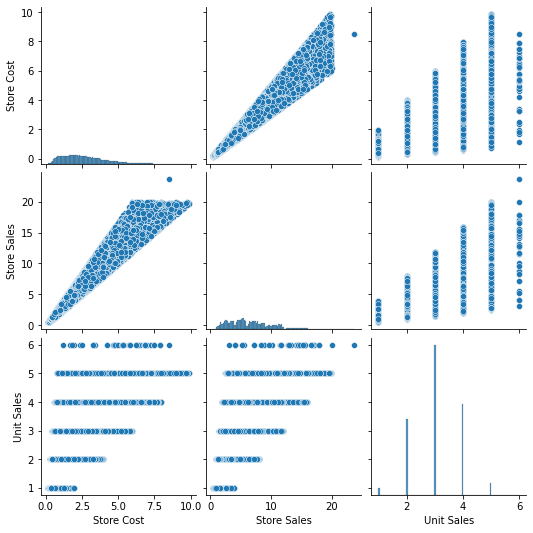

In [18]:
sns.pairplot(df[["Store Cost", "Store Sales", "Unit Sales"]])

In [19]:
df[["Store Cost", "Store Sales", "Unit Sales"]].corr()

,Store Cost,Store Sales,Unit Sales
Store Cost,1.000000,0.954650,0.492843
Store Sales,0.954650,1.000000,0.516071
Unit Sales,0.492843,0.516071,1.000000


## Design and build a relational DWH

- Create the database on Amazon RDS
- Design the relational schema of the DWH (which are the functional dependencies?)
- Upload the tables into rhw DWH

In [20]:
host = "sensor-dwh.cd97tkze3ics.us-east-1.rds.amazonaws.com"
port = 5432
user = "postgres"
pwd = "bigdata2022"
db = "postgres"

from sqlalchemy import create_engine
s = 'postgresql://{}:{}@{}:{}/{}'.format(user, pwd, host, str(port), db)
engine = create_engine(s)

Doing some ETL

In [21]:
# DT_customer
df[["C. City", "C. Country", "C. State", "Customer", "Yearly Income"]] \
    .drop_duplicates() \
    .to_sql('customer', engine, index=False, if_exists='replace')

In [22]:
# DT_store
df[["S. City", "S. Country", "S. State", "Store", "Type"]] \
    .drop_duplicates() \
    .to_sql('store', engine, index=False, if_exists='replace')

In [23]:
# DT_product
df[["Category", "Subcategory", "Family", "Product"]] \
    .drop_duplicates() \
    .to_sql('product', engine, index=False, if_exists='replace')

In [24]:
# DT_date
df[["Sales Date"]] \
    .drop_duplicates() \
    .to_sql('date', engine, index=False, if_exists='replace')

In [25]:
# FT
df[["Customer", "Store", "Product", "Sales Date", "Store Sales", "Store Cost", "Unit Sales"]] \
    .to_sql('sales', engine, index=False, if_exists='replace')

## Query the DWH with Tableau (Desktop)

- Import data from Amazon RDS into Tableau
- Join the tables
- Set `Sales Date` as a Datetime attribute both in the fact and dimension tables
- Build the dimensions and hierarchies in Tableau
- Complete the following exercises

### Exercise 1

1. Using a bar chart, display the `sum` of `Store Sales` for each `S. State`
     - Which state has the highest sales?
2. Drill down to view sales at the `S. City` level.
     - Are there cities with much lower sales than others?
3. How many stores (`Stores`) are there in each `S. State`? What about in each `S. City`?
     - Tip: Use `COUNTD` aggregation. Why?
4. Can low sales in some cities be imputed to the number of stores?
     - Display sales at the `S. City` level (as done above) and associate the color property with the number of distinct stores (`COUNTD(store)`)

### Exercise 2

5. Given the last visualization, associate the `S. Type` field with the color property.
    - What interesting pattern can you see?
6. Display the sales (`SUM`) for each `S. Type`.
    - What discrepancy is possible to notice with respect to the previous chart?
7. Associate the number of stores (`Store`) with the color property and the label property
    - What caused the discrepancy between the previous two visualizations?

### Exercise 3

8. Using a line chart, visualize the monthly sales trend
    - What pattern is present?
9. Divide the previous chart by `S. State` (one axis for each state)
    - Is the previous pattern present in each `State`?
    - Tip: by default the axes all have the same range: on any axis, right-click > `Edit Axis` > `Select Independent axis...`
10. Given the previous chart, visualize how much impact the various `Family`s have on total sales while maintaining the monthly trend visualization
    - What might be a good visualization?
    - Tip: associate each Family with a mark property and possibly change the mark type
    - Tip: you can change the mark type from the drop-down menu in the mark panel

## (Bonus) Plot the provenance graph

- Plot the provenance graph representing the previous transformations using the PROV standard

In [26]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image

def plot():
    # Create a new provenance document
    d1 = ProvDocument()  # d1 is now an empty provenance document
    
    d1.add_namespace('s3', 'https://s3.console.aws.amazon.com/s3')
    d1.add_namespace('rds', 'https://us-east-1.console.aws.amazon.com/rds')
    d1.add_namespace('unibo', 'https://www.unibo.it')
    d1.add_namespace('pd', 'https://pandas.pydata.org/')
    
    agent = d1.agent('unibo:mfrancia')

    DT_time = d1.entity('rds:DT_time')
    DT_customer = d1.entity('rds:DT_customer')
    DT_store = d1.entity('rds:DT_store')
    DT_product = d1.entity('rds:DT_product')
    FT = d1.entity('rds:FT')
    
    etl = d1.activity('pd:etl')
    d1.wasGeneratedBy(DT_time, etl)
    d1.wasGeneratedBy(DT_customer, etl)
    d1.wasGeneratedBy(DT_store, etl)
    d1.wasGeneratedBy(DT_product, etl)
    d1.wasGeneratedBy(FT, etl)
    
    processed_dataset = d1.entity('s3:sales_fact_1997.v0.0.1.csv')  # create an entity representing the processed dataset
    d1.used(etl, processed_dataset)  # the activity used the dataset as input
    append = d1.activity('pd:append')  # create the processing activity
    d1.wasGeneratedBy(processed_dataset, append)  # the processed dataset has been created by the `append` activity
    
    for file_name in file_names:
        original_dataset = d1.entity('s3:' + file_name)  # register the original datasets
        d1.wasAttributedTo(original_dataset, agent)  # attribute the dataset to the agent who created it
        d1.wasDerivedFrom(processed_dataset, original_dataset)  # the processed dataset has been derived from the original one
        d1.used(append, original_dataset)  # the activity used the dataset as input

    # visualize the graph
    dot = prov_to_dot(d1)
    dot.write_png('prov.png')
    return Image('prov.png')

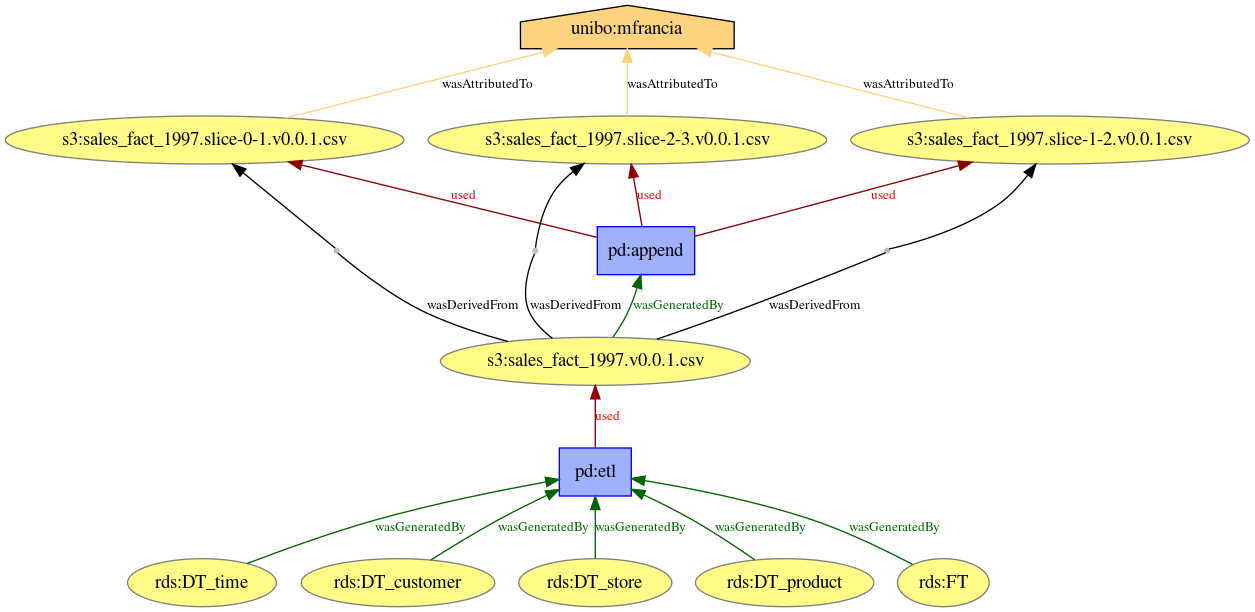

In [27]:
plot()